PCA bada zmienność, techniki skalowania badają odległości między obiektami.
W PCA badamy jedynie zależności liniowe.
W PCA powinna być zachowana wielowymiarowa normalność danych.

In [922]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import bartlett

In [923]:
#wczytanie danych
data = pd.read_csv('data/abalone.csv')
#wyrzucenie pierwszej zmiennej nie-numerycznej, odpowiedzialnej za płeć
data.drop(data.columns[:1], axis=1, inplace=True)

In [924]:
#odfiltrowanie danych dla których którakolwiek ze zmiennych jest równa 0
data = data[(data.T != 0).all()]

In [925]:
data

,LongestShell,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [926]:
data.describe().drop('count').round(4)

,LongestShell,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
mean,0.5241,0.4079,0.1396,0.8290,0.3595,0.1807,0.2388,9.9351
std,0.1201,0.0992,0.0417,0.4903,0.2220,0.1096,0.1392,3.2242
min,0.0750,0.0550,0.0100,0.0020,0.0010,0.0005,0.0015,1.0000
25%,0.4500,0.3500,0.1150,0.4422,0.1862,0.0935,0.1300,8.0000
50%,0.5450,0.4250,0.1400,0.8000,0.3360,0.1710,0.2340,9.0000
75%,0.6150,0.4800,0.1650,1.1535,0.5020,0.2530,0.3288,11.0000
max,0.8150,0.6500,1.1300,2.8255,1.4880,0.7600,1.0050,29.0000


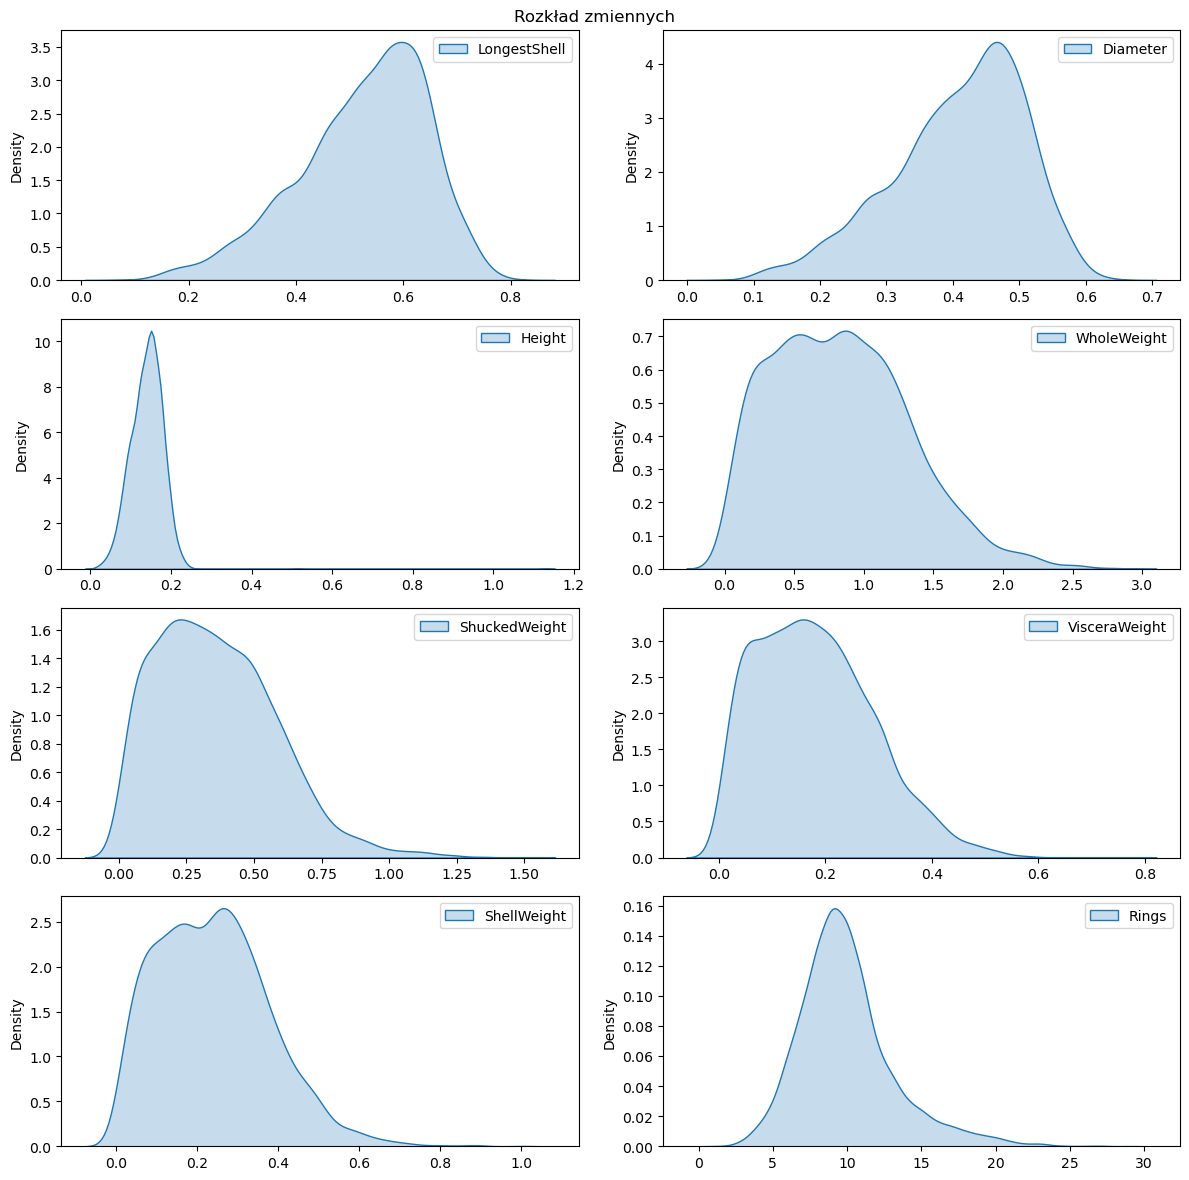

In [927]:
#wykresy gęstości zmiennych
fig, axes = plt.subplots(4, 2, figsize=(12, 12))

for i, column in enumerate(data.columns):
    row = i // 2
    col = i % 2
    sns.kdeplot(data[column], shade=True, label=column, ax=axes[row, col])
    #axes[row, col].set_ylim(-0.1, 1)
    axes[row, col].set_xlabel('')
    axes[row, col].legend()

plt.suptitle('Rozkład zmiennych')
plt.tight_layout()
plt.show()

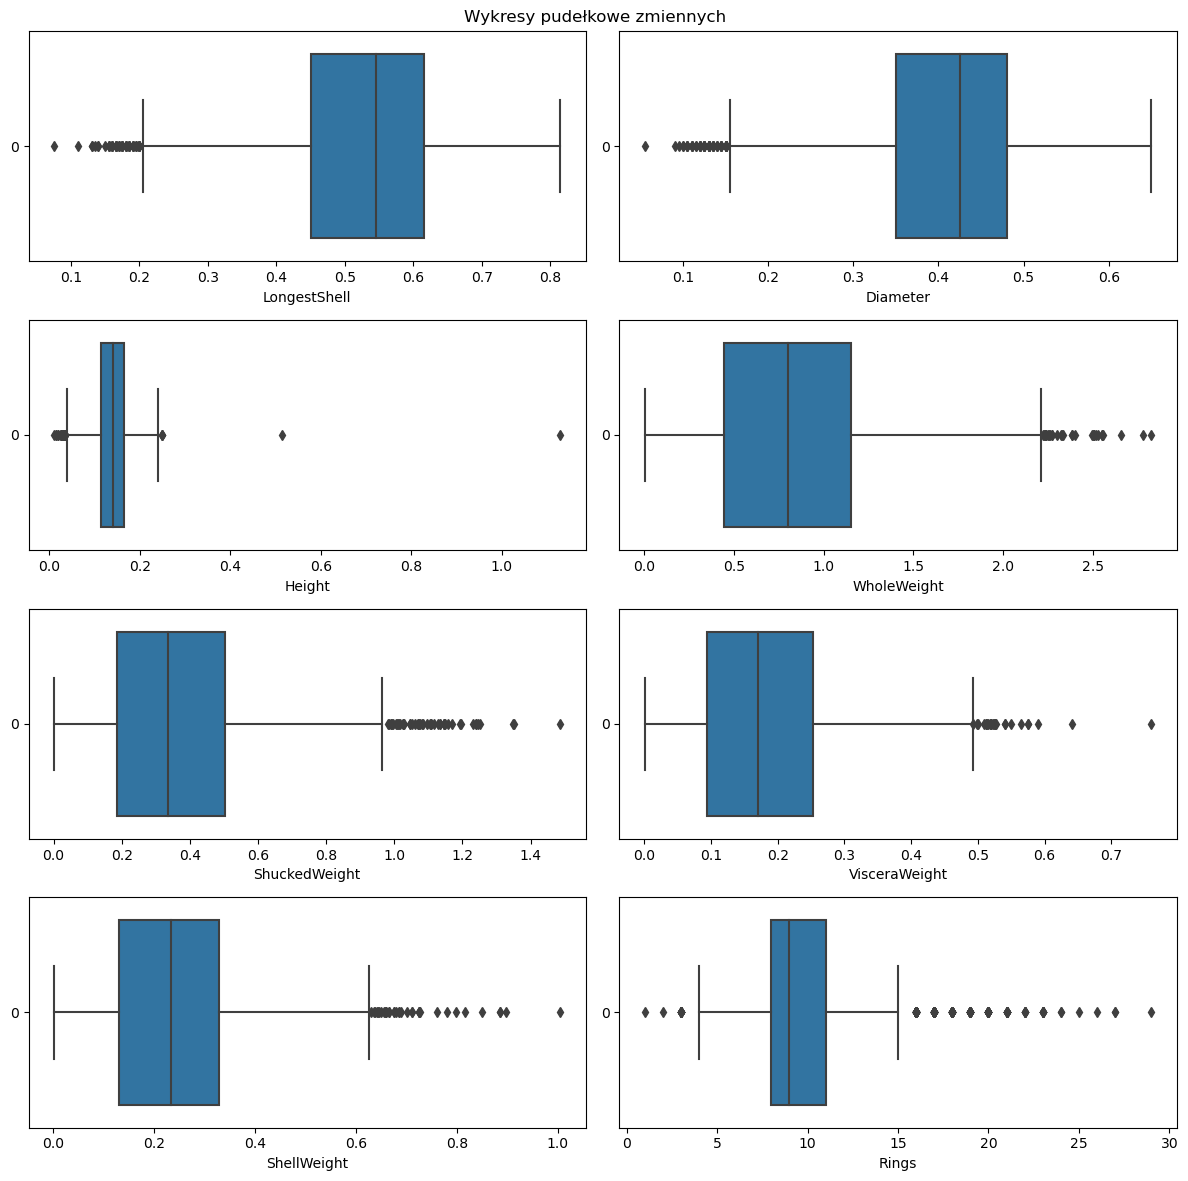

In [928]:
#wykresy pudełkowe dla każdej zmiennej
fig, axes = plt.subplots(4, 2, figsize=(12, 12))

for i, column in enumerate(data.columns):
    row = i // 2
    col = i % 2
    sns.boxplot(data[column], ax=axes[row, col], orient='h')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel("")

plt.suptitle('Wykresy pudełkowe zmiennych')
plt.tight_layout()
plt.show()


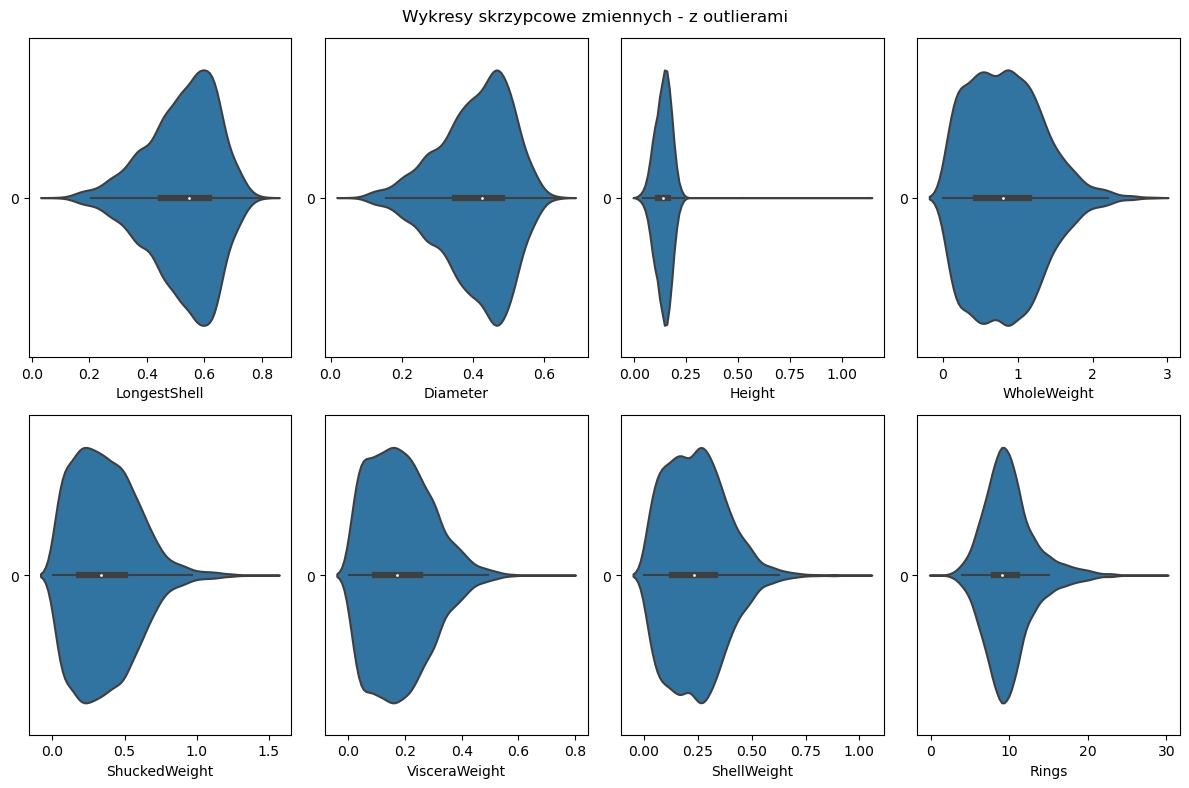

In [929]:
#wykresy skrzypcowe dla każdej zmiennej przed wyrzuceniem outlierów
fig, axes = plt.subplots(2, 4, figsize=(12, 8))

for i, column in enumerate(data.columns):
    row = i // 4
    col = i % 4
    sns.violinplot(data[column], ax=axes[row, col],orient='h')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel("")

plt.suptitle('Wykresy skrzypcowe zmiennych - z outlierami')
plt.tight_layout()
plt.show()

In [930]:
#pozbycie się outlierów za pomocą IQR
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]

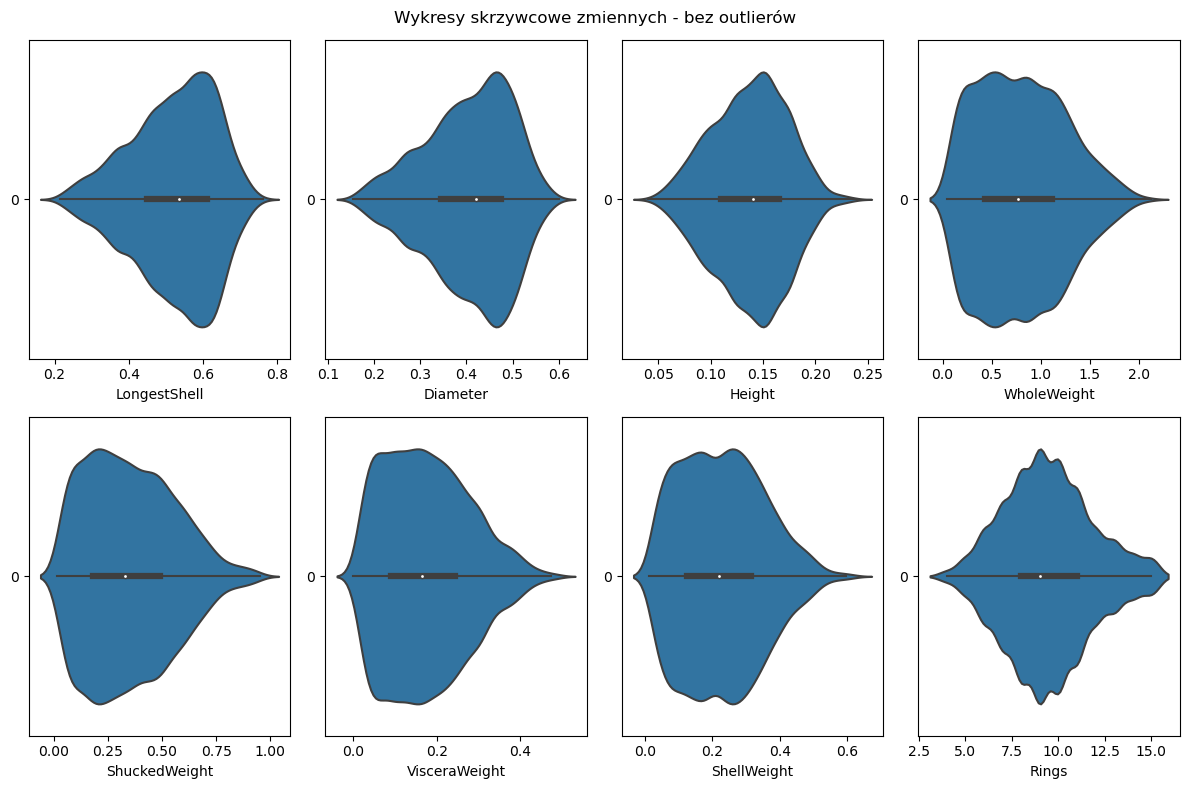

In [931]:
#wykresy skrzywcowe dla każdej zmiennej po wyrzuceniu outlierów
fig, axes = plt.subplots(2, 4, figsize=(12, 8))

for i, column in enumerate(data.columns):
    row = i // 4
    col = i % 4
    sns.violinplot(data[column], ax=axes[row, col],orient='h')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel("")

plt.suptitle('Wykresy skrzywcowe zmiennych - bez outlierów')
plt.tight_layout()
plt.show()


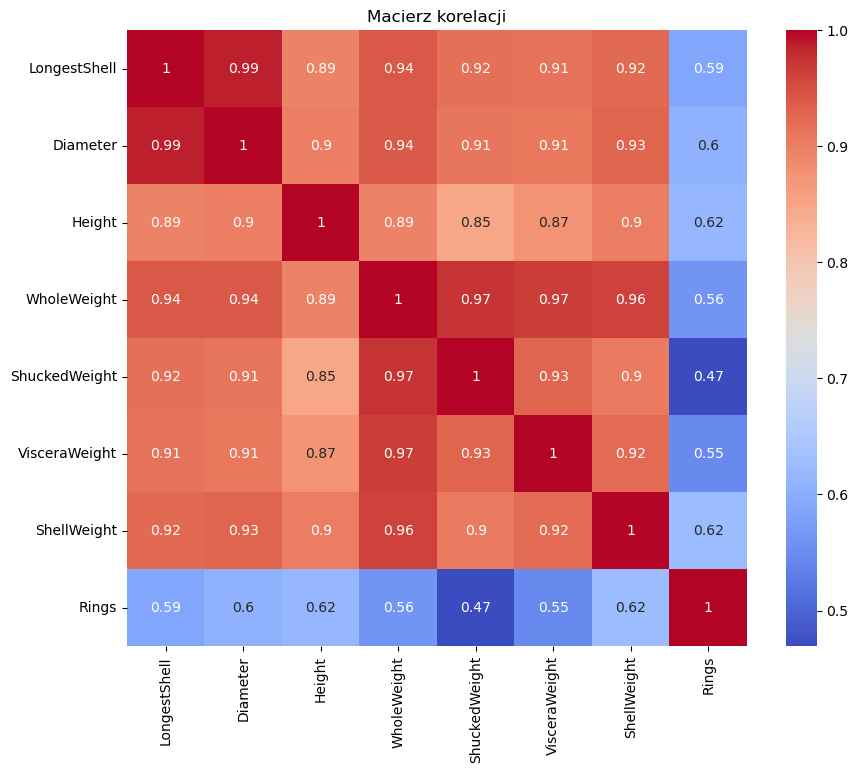

In [932]:
#wizualizacja macierzy korelacji między zmiennymi
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Macierz korelacji')
plt.show()

In [933]:
#sprawdzenie testem Bartletta czy dane są odpowiednio powiązane
#H0: dane są niepowiązane
#H1: dane są powiązane
bartlett_ = bartlett(data['LongestShell'], data['Diameter'], data['Height'], data['WholeWeight'], data['ShuckedWeight'],data['VisceraWeight'], data['ShellWeight'], data['Rings'])
stat, p_value = bartlett(data['LongestShell'], data['Diameter'], data['Height'], data['WholeWeight'], data['ShuckedWeight'],data['VisceraWeight'], data['ShellWeight'], data['Rings'])
if p_value > 0.05:
    print('Dane nie są dostatecznie powiązane')
else:
    print('Dane są dostatecznie powiązane')

Dane są dostatecznie powiązane


In [934]:
#standaryzacja danych
columns = data.columns
data = pd.DataFrame(StandardScaler().fit_transform(data))
data.columns = columns

In [935]:
#stworzenie modelu PCA i transformacja danych na jego podstawie
pca = PCA()
pca_data = pca.fit_transform(data)
#zamiana macierzy na dataframe i nadanie nazw kolumn
pca_data = pd.DataFrame(pca_data)
pca_data.columns = ['PC' + str(i) for i in range(1, len(pca_data.columns) + 1)]

In [936]:
#calculate eigenvectors and eigenvalues
cov_matrix = np.cov(data.T)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
eigenvectors = pd.DataFrame(eigenvectors, columns=['PC' + str(i) for i in range(1, len(pca_data.columns) + 1)], index=data.columns)
#wyznaczenie wartości własnych (wariancji poszczególnych składowych głównych)
eigenvalues = pd.DataFrame(eigenvalues, columns=["STD"], index=['PC' + str(i) for i in range(1, len(pca_data.columns) + 1)])

In [937]:
eigenvectors

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
LongestShell,0.369300,-0.068230,0.228764,-0.544685,-0.141110,0.039477,0.698885,0.005979
Diameter,0.369785,-0.037922,0.262421,-0.526873,-0.088261,-0.047823,-0.710801,0.006788
Height,0.356319,0.044044,0.711507,0.547315,0.085361,0.240435,0.013286,0.005289
WholeWeight,0.373713,-0.146432,-0.281444,0.123552,0.140963,-0.044156,0.000329,0.850059
ShuckedWeight,0.360003,-0.274032,-0.360661,-0.018789,0.565598,0.435729,-0.020621,-0.393304
VisceraWeight,0.364631,-0.145845,-0.339282,0.271901,-0.768730,0.151322,-0.045981,-0.201923
ShellWeight,0.368933,-0.005240,-0.066093,0.189066,0.178013,-0.840785,0.059404,-0.285676
Rings,0.248158,0.934951,-0.209264,-0.029585,0.051037,0.129303,0.008714,-0.014777


In [938]:
eigenvalues

,STD
PC1,6.916791
PC2,0.647605
PC3,0.153803
PC4,0.127972
PC5,0.063873
PC6,0.072046
PC7,0.013351
PC8,0.006675


In [939]:
#wyznaczenie wektorów własnych (wag poszczególnych zmiennych używanych do wyznaczenia składowych głównych)
loadings = pd.DataFrame(pca.components_.T, columns=['PC' + str(i) for i in range(1, len(pca_data.columns) + 1)], index=data.columns)

In [940]:
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
LongestShell,0.369300,-0.068230,0.228764,0.544685,-0.039477,0.141110,0.698885,-0.005979
Diameter,0.369785,-0.037922,0.262421,0.526873,0.047823,0.088261,-0.710801,-0.006788
Height,0.356319,0.044044,0.711507,-0.547315,-0.240435,-0.085361,0.013286,-0.005289
WholeWeight,0.373713,-0.146432,-0.281444,-0.123552,0.044156,-0.140963,0.000329,-0.850059
ShuckedWeight,0.360003,-0.274032,-0.360661,0.018789,-0.435729,-0.565598,-0.020621,0.393304
VisceraWeight,0.364631,-0.145845,-0.339282,-0.271901,-0.151322,0.768730,-0.045981,0.201923
ShellWeight,0.368933,-0.005240,-0.066093,-0.189066,0.840785,-0.178013,0.059404,0.285676
Rings,0.248158,0.934951,-0.209264,0.029585,-0.129303,-0.051037,0.008714,0.014777


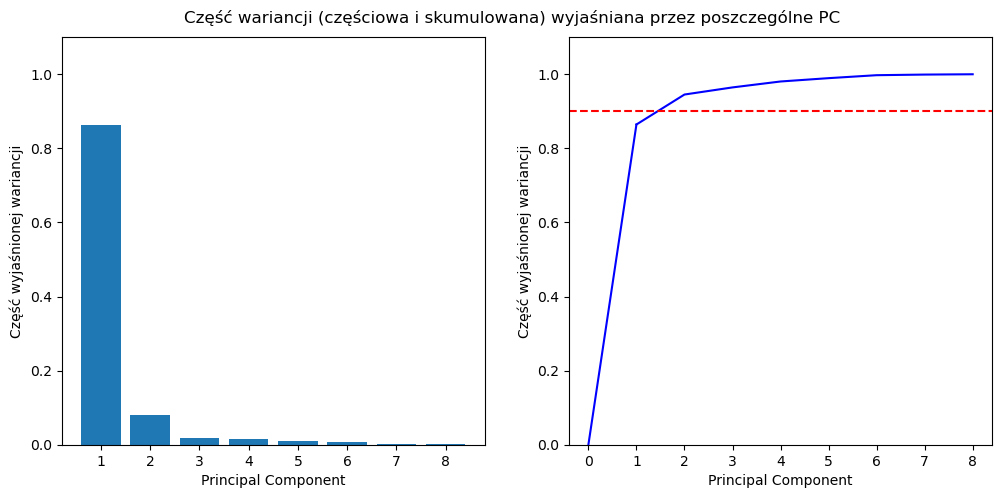

In [941]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#wykres przedstawiający jaką część wariancji wyjaśnia każda zmienna
axes[0].bar(x=range(1, len(pca.explained_variance_ratio_) + 1), height=pca.explained_variance_ratio_, label='Część wyjaśnionej wariancji')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Część wyjaśnionej wariancji')
axes[0].set_ylim(0,1.1)

#skumulowana część wyjaśnionej wariancji
axes[1].plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), color="blue", label='Skumulowana część wyjaśnionej wariancji')
axes[1].set_xlabel('Principal Component')
axes[1].set_ylabel('Część wyjaśnionej wariancji')
axes[1].axhline(y=0.9, color='r', linestyle='--')

#stworzenie linii łączącej wykres liniowy z punktem (0,0)
axes[1].plot([0, 1], [0, pca.explained_variance_ratio_[0]], color="blue")
axes[1].set_ylim(0,1.1)

#dodanie tytułu do wykresu
fig.suptitle('Część wariancji (częściowa i skumulowana) wyjaśniana przez poszczególne PC')
fig.subplots_adjust(top=0.925)

plt.show()

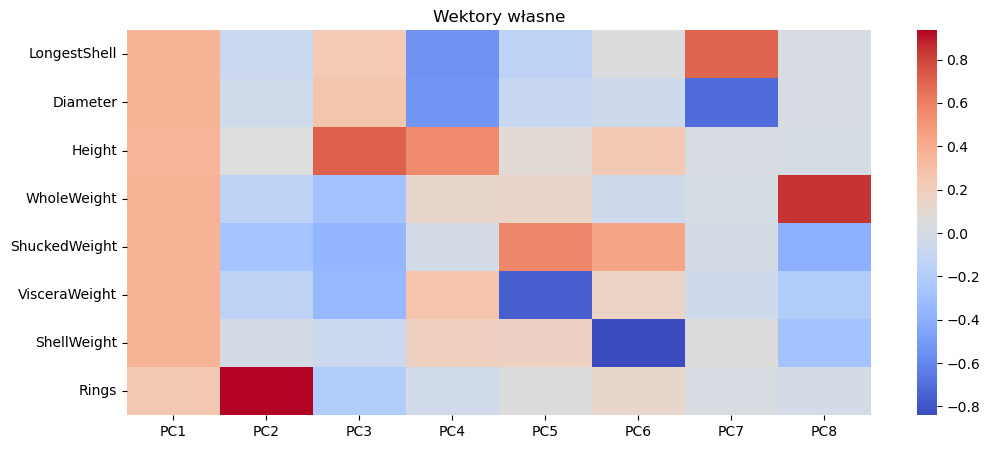

In [942]:
#mapa ciepła udziałów zmiennych w poszczególnych składowych głównych
fig, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(eigenvectors, cmap='coolwarm', ax=ax)
ax.set_title('Wektory własne')
plt.show()

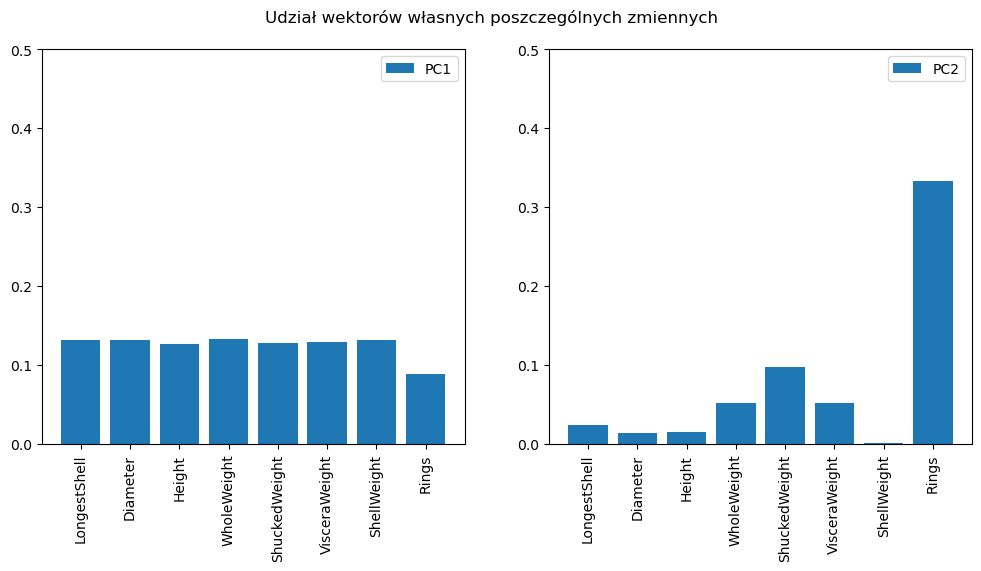

In [943]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(x=eigenvectors.index, height=abs(eigenvectors["PC1"])/abs(sum(eigenvectors["PC1"])), label="PC1")
axes[0].set_xticklabels(eigenvectors.index, rotation=90)
axes[0].set_ylim(0,0.5)
axes[0].legend()

axes[1].bar(x=eigenvectors.index, height=abs(eigenvectors["PC2"])/abs(sum(eigenvectors["PC1"])), label="PC2")
axes[1].set_xticklabels(eigenvectors.index, rotation=90)
axes[1].set_ylim(0,0.5)
axes[1].legend()

fig.suptitle("Udział wektorów własnych poszczególnych zmiennych")
fig.subplots_adjust(top=0.9)

plt.show()

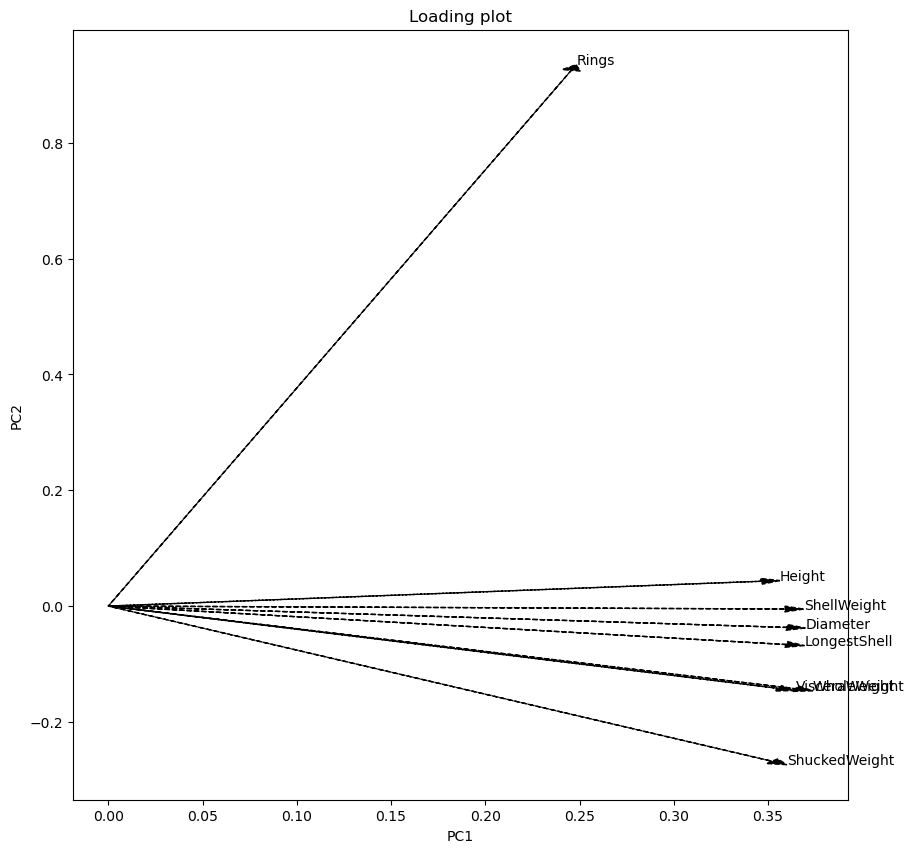

In [944]:
#create a loading plot for PC1 and PC2
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x=loadings["PC1"], y=loadings["PC2"], color="black",alpha=0)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("Loading plot")

# add variable names to points
for i, txt in enumerate(loadings.index):
    ax.annotate(txt, (loadings["PC1"][i], loadings["PC2"][i]))

# add lines from (0,0) to each point with arrows
for i in range(len(loadings)):
    ax.arrow(0, 0, loadings["PC1"][i], loadings["PC2"][i], color="black", linestyle="--", width=0.0001, head_width=0.01, head_length=0.01, length_includes_head=True)
plt.show()

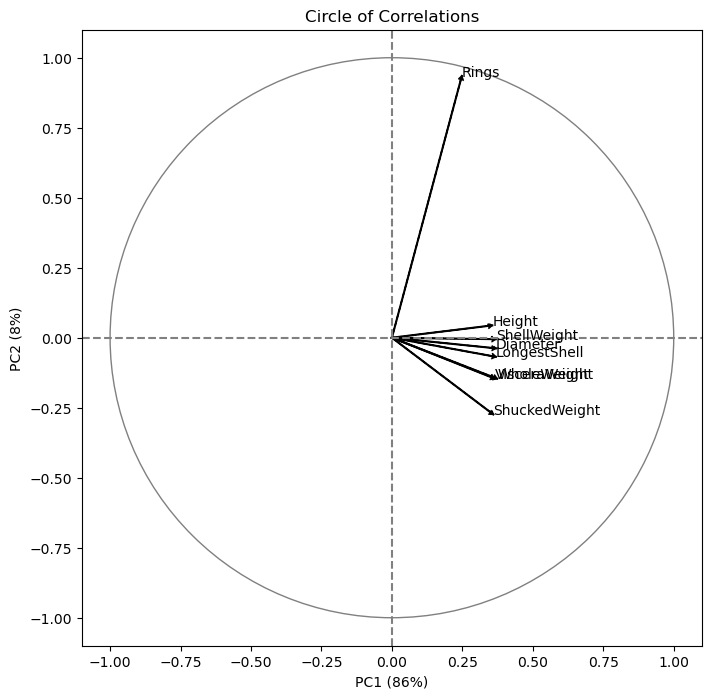

In [945]:
#github.com/mazieres
def circleOfCorrelations(pc_infos, ebouli):
	fig = plt.figure(figsize=(8,8))
	circle1=plt.Circle((0,0),radius=1, color='grey', fill=False)
	fig = plt.gcf()
	fig.gca().add_artist(circle1)
	for idx in range(len(pc_infos["PC1"])):
		x = pc_infos["PC1"][idx]
		y = pc_infos["PC2"][idx]
		plt.plot([0.0,x],[0.0,y],'k-')
		plt.arrow(0, 0, x, y, color="black", linestyle="--", width=0.0001, head_width=0.02, head_length=0.015, length_includes_head=True)
		plt.annotate(pc_infos.index[idx], xy=(x,y))
	plt.xlabel("PC1 (%s%%)" % str(ebouli[0])[:4].lstrip("0."))
	plt.ylabel("PC2 (%s%%)" % str(ebouli[1])[:4].lstrip("0."))
	plt.axhline(y=0, color='grey', linestyle='--')
	plt.axvline(x=0, color='grey', linestyle='--')
	plt.xlim((-1.1,1.1))
	plt.ylim((-1.1,1.1))
	plt.title("Circle of Correlations")

circleOfCorrelations(loadings, pca.explained_variance_ratio_)